In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm_notebook
np.set_printoptions(suppress=True)
from sklearn import preprocessing
from tqdm import tqdm
import decimal
from itertools import combinations
from random import shuffle
from time import sleep
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
import gc
import datetime
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import os
from sklearn.metrics import roc_auc_score
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
import random
import lightgbm as lgb

In [2]:
#Always seed the randomness of this universe
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
seed_everything(seed=51)

In [4]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

In [5]:
train_dtypes = pd.read_csv('../input/train9_dtypes.csv')
test_dtypes = pd.read_csv('../input/test9_dtypes.csv')
train_dtypes.index = train_dtypes['TransactionID']
del train_dtypes['TransactionID']
test_dtypes.index = test_dtypes['TransactionID']
del test_dtypes['TransactionID']
train_dtypes = train_dtypes.iloc[:,0]
test_dtypes = test_dtypes.iloc[:,0]
print(type(train_dtypes),type(test_dtypes))
train_dtypes = train_dtypes.to_dict()
test_dtypes = test_dtypes.to_dict()
gc.collect()

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


21

In [6]:
%%time
train = pd.read_csv('../input/train_PI_1ekim.csv',dtype= train_dtypes)
print("train finished")

train finished
CPU times: user 23.6 s, sys: 1.13 s, total: 24.7 s
Wall time: 24.7 s


In [7]:
%%time
test = pd.read_csv('../input/test_PI_1ekim.csv',dtype= test_dtypes)
print("test finished")

test finished
CPU times: user 20.4 s, sys: 679 ms, total: 21.1 s
Wall time: 21.1 s


In [8]:
#sample_submission
sample_submission = pd.read_csv('../input/sample_submission.csv')
print(train.shape,test.shape,sample_submission.shape)

(590540, 359) (506691, 358) (506691, 2)


# Train data is subsampled

# Training

In [9]:
[x for x in train.columns if x in ['TransactionID','TransactionDT','dayofyear','day']]

['TransactionID']

In [10]:
train.drop(['TransactionID'],axis=1,inplace=True)
test.drop(['TransactionID'],axis=1,inplace=True)
gc.collect()

642

In [11]:
train.head()

,isFraud,C1,C10,C10_fq_enc,C11,C11_fq_enc,C12,C12_fq_enc,C13,C14,C14_fq_enc,C1_fq_enc,C2,C2_fq_enc,C3,C4,C4_fq_enc,C6_fq_enc,C7,C8,C8_fq_enc,D13,DT_M,DeviceInfo,DeviceInfo_999999,DeviceInfo_fq_enc,DeviceType,DeviceType_mobile,M4,M5,M6,P_emaildomain,Pemaildomain_DeviceInfo,Pemaildomain_mail.com,Pemaildomain_outlook.com,Pemaildomain_protonmail,ProductCD,ProductCD_DeviceInfo,ProductCD_card3,ProductCD_card5,ProductCD_dist2,R_emaildomain,R_emaildomain_bin,R_emaildomain_prefix,Remaildomain_DeviceInfo,Remaildomain_icloud.com,Remaildomain_lesscategory,Remaildomain_protonmail,V149,V152,V154,V156,V187,V189,V198,V201,V243,V245,V248,V249,V252,V256,V257,V258,V259,V261,V281,V33,V34,V44,V45,V57,V58,V61,V62,V67,V79,V81,V82,V83,V86,V87,V94,card1_fraudulent,card2_fraudulent,card3_185.0,card3_DeviceInfo,card3_TransactionAmt_mean,card4_count_full,card5_TransactionAmt_mean,card5_TransactionAmt_std,card6,card6_count_full,device_name_fq_enc,dist1_91.0,email_check,id03subtractid04,id03sumid04,id13_52.0,id14_999999,id14_999999.0,id19_321.0,id19_427.0,id20_127.0,id20_333.0,id20_417.0,id20_507.0,id20_638.0,id31_firefox,id31_opera,id33_1280x720,id33_2208x1242,id_01,id_03,id_17,id_31,is_debit,uid2_TransactionAmt_mean,uid3,uid_TransactionAmt_mean,C13_fq_enc,C5,C7_fq_enc,C_nansum,DeviceInfo_Trident/7.0,TransactionAmt_decimal_0.0,V103,V138,V140,V153,V16,V170,V172,V175,V180,V188,V190,V192,V194,V199,V205,V220,V225,V227,V232,V237,V239,V244,V246,V251,V262,V266,V282,V283,V29,V294,V295,V296,V313,V315,V317,V322,V323,V324,V326,V331,V47,V48,V54,V55,V66,V69,V70,V76,V85,V90,V91,V_nanmedian,addr2_fq_enc,card2_TransactionAmt_std,card3_TransactionAmt_std,card3_addr2,card3_count_full,card3_fq_enc,dist1_86.0,id09sumid10,id19_216.0,id33_firstframe,id_32,C_nanstd,D14,D8,DT_D,DT_M_total,DT_W,DT_W_total,P_emaildomain_fq_enc,P_emaildomain_prefix,ProductCD_addr1,R_emaildomain_fq_enc,TransactionAmt,TransactionAmt_check,TransactionAmt_decimal,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4,V200,V215,V241,V253,V254,V255,V277,V278,V39,addr1,addr1_addr2,addr1_fq_enc,addr2,card1,card1_addr1,card1_count_full,card1_fq_enc,card2,card2_TransactionAmt_mean,card2_fq_enc,card4,device_name,id05subtractid06,id05sumid06,id09subtractid10,id13_27.0,id13_999999,id18_15.0,id19_153.0,id19_266.0,id19_384.0,id20_325.0,id_06,id_13,id_14,id_16,id_20,id_38,relative_hour,uid2,uid2_fq_enc,uid3_TransactionAmt_mean,uid3_TransactionAmt_std,uid3_fq_enc,uid4,uid_DT_M,uid_DT_W,uid_fq_enc,group_1_mean,group_1_median,group_1_min,group_1_max,group_1_sum,group_1_std,group_1_kurtosis,group_2_mean,group_2_median,group_2_min,group_2_max,group_2_sum,group_2_std,group_2_kurtosis,group_3_mean,group_3_median,group_3_min,group_3_max,group_3_sum,group_3_std,group_3_kurtosis,group_4_mean,group_4_median,group_4_min,group_4_max,group_4_sum,group_4_std,group_4_kurtosis,group_5_mean,group_5_median,group_5_min,group_5_max,group_5_sum,group_5_std,group_5_kurtosis,group_6_mean,group_6_median,group_6_min,group_6_max,group_6_sum,group_6_std,group_6_kurtosis,group_7_mean,group_7_median,group_7_min,group_7_max,group_7_sum,group_7_std,group_7_kurtosis,group_8_mean,group_8_median,group_8_min,group_8_max,group_8_sum,group_8_std,group_8_kurtosis,group_9_mean,group_9_median,group_9_min,group_9_max,group_9_sum,group_9_std,group_9_kurtosis,group_10_mean,group_10_median,group_10_min,group_10_max,group_10_sum,group_10_std,group_10_kurtosis,group_11_mean,group_11_median,group_11_min,group_11_max,group_11_sum,group_11_std,group_11_kurtosis,group_12_mean,group_12_median,group_12_min,group_12_max,group_12_sum,group_12_std,group_12_kurtosis,group_13_mean,group_13_median,group_13_min,group_13_max,group_13_sum,group_13_std,group_13_kurtosis,group_14_mean,group_14_median,group_14_min,group_14_max,group_14_sum,group_14_std,group_14_kurtosis,group_15_mean,group_15_median,group_15_min,group_15_max,group_15_sum,group_15_std,group_15_kurtosis
0,0,1.0,0.0,824420,2.0,168780,0.0,856080,1.0,1.0,598520,586742,1.0,581696,0.0,0.0,823454,631237,0.0,0.0,81630

In [12]:
y = train['isFraud']
del train['isFraud']

In [13]:
########################### Model params
lgb_params = {'num_leaves': 546,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.1797454081646243,
          'bagging_fraction': 0.2181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3299927210061127,
          'reg_lambda': 0.3885237330340494,
          'random_state': 42,
}

In [14]:
N = 5
kf = KFold(n_splits=N)

importance = pd.DataFrame(np.zeros((train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=train.columns)
scores = []
y_pred = np.zeros(test.shape[0])
oof = np.zeros(train.shape[0])

for fold, (trn_idx, val_idx) in enumerate(kf.split(train, y), 1):
    print('Fold {}'.format(fold))
          
    trn_data = lgb.Dataset(train.iloc[trn_idx, :].values, label=y.iloc[trn_idx].values)
    val_data = lgb.Dataset(train.iloc[val_idx, :].values, label=y.iloc[val_idx].values)   
    
    #params, dtrain, 1600, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500
    clf = lgb.train(lgb_params, trn_data ,2000 ,valid_sets=[trn_data, val_data], verbose_eval=200,early_stopping_rounds=100)

    predictions = clf.predict(train.iloc[val_idx, :].values) 
    importance.iloc[:, fold - 1] = clf.feature_importance()
    oof[val_idx] = predictions

    score = roc_auc_score(y.iloc[val_idx].values, predictions)
    scores.append(score)
    print('Fold {} ROC AUC Score {}\n'.format(fold, score))

    y_pred += clf.predict(test) / N
    
    del trn_data, val_data, predictions
    gc.collect()
    
print('Average ROC AUC Score {} [STD:{}]'.format(np.mean(scores), np.std(scores)))

Fold 1
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.970216	valid_1's auc: 0.90263
[400]	training's auc: 0.989503	valid_1's auc: 0.916389
[600]	training's auc: 0.99639	valid_1's auc: 0.924226
[800]	training's auc: 0.998839	valid_1's auc: 0.928349
[1000]	training's auc: 0.999637	valid_1's auc: 0.930061
[1200]	training's auc: 0.999889	valid_1's auc: 0.93108
[1400]	training's auc: 0.999968	valid_1's auc: 0.931495
Early stopping, best iteration is:
[1473]	training's auc: 0.999979	valid_1's auc: 0.931573
Fold 1 ROC AUC Score 0.9315727633298687

Fold 2
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.969079	valid_1's auc: 0.92374
[400]	training's auc: 0.989509	valid_1's auc: 0.936658
[600]	training's auc: 0.996811	valid_1's auc: 0.942345
[800]	training's auc: 0.999116	valid_1's auc: 0.944664
[1000]	training's auc: 0.999747	valid_1's auc: 0.945655
[1200]	training's auc: 0.999933	valid_1's auc: 0.945745
Early stoppi

In [15]:
print(roc_auc_score(y,oof))

0.9404538987108759


In [16]:
importance['avg'] = importance.mean(axis=1)

In [17]:
importance = importance.sort_values(by='avg',ascending=False)

In [18]:
importance = importance.reset_index(drop=False)

In [19]:
importance.head()

,index,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg
0,relative_hour,17668,15763,10432,15509,13080,14490.4
1,DT_D,19747,14120,8050,13244,13895,13811.2
2,uid3_TransactionAmt_mean,16989,14875,9480,14388,12858,13718.0
3,uid3_fq_enc,17438,13978,9861,13779,12984,13608.0
4,card1_addr1,16486,12067,9105,11625,13087,12474.0


In [20]:
importance.to_csv('../importances/importances29.csv',index=False)

In [21]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [22]:
sample_submission['isFraud'] = y_pred

In [23]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.000552
1,3663550,0.000911
2,3663551,0.001499
3,3663552,0.000965
4,3663553,0.000681


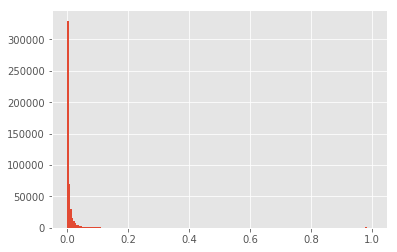

In [24]:
plt.hist(sample_submission['isFraud'],bins=200)
plt.show()

In [25]:
sample_submission.to_csv('../predictions/pred29.csv',index=False)

In [26]:
!kaggle competitions submit -c ieee-fraud-detection -f ../predictions/pred29.csv -m "pred29"

100%|███████████████████████████████████████| 14.2M/14.2M [00:31<00:00, 463kB/s]
Successfully submitted to IEEE-CIS Fraud Detection